In [1]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title import `matplotlib` `sklearn` and set defaults
# install packages to visualize brains and electrode locations

!pip install mne --quiet

import mne
from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet, tfr_array_morlet)
from mne.viz import centers_to_edges

from matplotlib import rcParams
from matplotlib import pyplot as plt
import sklearn

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn import svm

import scipy
from scipy import signal

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 7.5 MB 26.1 MB/s 


## SVM pipeline

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

print(alldat[1][0].keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [5]:
# @title select channels
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)


# for each subj: ele * time point matrix 

# for isub in range(7):
#  data = np.hstack((data, data_sub))
# data = np.hstack((data, data_tmp))

In [6]:
def get_data_label(sub_ID, roi_ID, condi_ID):
  dat = alldat[sub_ID][condi_ID] 

  ele_used = electrode_indexes[roi_ID][sub_ID]

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below 200 Hz
  b, a = signal.butter(3, [200], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above 1 Hz
  b, a = signal.butter(3, [1], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power
  V_tmp = signal.hilbert(V)
  V = np.abs(V_tmp) ** 2

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  data = np.mean(V_epochs, 1)
  label = dat['stim_id']

  return data, label


In [7]:
def get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit):
  from scipy import signal

  dat = alldat[sub_ID][condi_ID] 

  ele_used = np.concatenate((electrode_indexes[0][sub_ID],electrode_indexes[1][sub_ID]), axis=0)
  # print(ele_used)

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below 200 Hz
  b, a = signal.butter(3, band_limit[1], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above 1 Hz
  b, a = signal.butter(3, band_limit[0], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power
  if band_limit[0] > 1:
    V_tmp = signal.hilbert(V) # 8-12
    V = np.abs(V_tmp) ** 2

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  data = np.empty((nstim,0),int)

  for it in range(50):
    V_epochs_tmp = V_epochs[:, [it * 20 + time_ID * 1000, (it + 1) * 20 - 1 + time_ID * 1000], :]
    data_tmp = np.mean(V_epochs_tmp, 1)
    data = np.hstack((data, data_tmp))

  label = dat['stim_id']

  return data, label

In [8]:
def get_data_label_allroi_alltime(sub_ID, condi_ID, band_limit):
  from scipy import signal

  dat = alldat[sub_ID][condi_ID] 

  ele_used = np.concatenate((electrode_indexes[0][sub_ID],electrode_indexes[1][sub_ID]), axis=0)
  # print(ele_used)

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below 200 Hz
  b, a = signal.butter(3, band_limit[1], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above 1 Hz
  b, a = signal.butter(3, band_limit[0], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # calculate the power
  if band_limit[0] > 1:
    V_tmp = signal.hilbert(V) # 8-12
    V = np.abs(V_tmp) ** 2

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  data = np.empty((nstim,0),int)

  for itime in range(20):
    V_epochs_tmp = V_epochs[:, [itime * 100, (itime + 1) * 100 - 1], :]
    data_tmp = np.mean(V_epochs_tmp, 1)
    data = np.hstack((data, data_tmp))

  label = dat['stim_id']

  return data, label

In [9]:
# classifier

# for example sub
# sub_ID : 0-6
# roi_ID : 0 precentral area; 1 postcentral area
# condi_ID : 0 actual; 1 imagery
# time_ID : 0 0-999; 1 1000-1999

def train_svm(sub_ID, roi_ID, condi_ID, time_ID, band_limit):
  data, label = get_data_label_allroi(sub_ID, condi_ID, time_ID, band_limit)
  # data, label = get_data_label_allroi_alltime(sub_ID, condi_ID, band_limit)
  # print(data.shape)
  accuracies = np.ones(60)
  train_accuracies = np.ones(60)

  loo = LeaveOneOut()
  loo.get_n_splits(data)
  # print(loo)
  for train_index, test_index in loo.split(data):
    classifier = svm.SVC(C = 1, kernel = 'linear')
      #Cfloat, default=1.0
      #Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

      # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
      # Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).
    classifier.fit(data[train_index], label[train_index])
    # print(data[train_index].shape)

    train_accuracies[test_index] = classifier.score(data[train_index], label[train_index])
    accuracies[test_index] = classifier.score(data[test_index], label[test_index])

  # generalization
  gen_data, gen_label = get_data_label_allroi(sub_ID, 1-condi_ID, time_ID, band_limit)
  # gen_data, gen_label = get_data_label_allroi_alltime(sub_ID, 1-condi_ID, time_ID, band_limit)
  classifier = svm.SVC(C = 1, kernel = 'rbf')
  classifier.fit(data, label)
  gen_acc = classifier.score(gen_data, gen_label)

  return accuracies.mean(), train_accuracies.mean(), gen_acc

# basic setting
band_limit = [13, 30]
band_name = 'beta band';
acc = np.ones(shape=(2,7,2))
train_acc = np.ones(shape=(2,7,2))
gen_acc = np.ones(shape=(2,7,2))
condi_name = ['actual', 'imagery']
gen_name = ['actual→imagery', 'imagery→actual']

for itime in range(2):
  for icondi in range(2):
    for isub in range(7):
     acc[itime][isub][icondi], train_acc[itime][isub][icondi], gen_acc[itime][isub][icondi]= train_svm(isub, 0, icondi, itime, band_limit)

    print("time: ", itime, "-", itime + 1, "s")
    print("training score: ", condi_name[icondi], np.mean(train_acc[itime, :, icondi], 0))
    print("cross-validation score: ", condi_name[icondi], np.mean(acc[itime, :, icondi], 0))
    print("generalization score: ", gen_name[icondi], np.mean(gen_acc[itime, :, icondi], 0))


time:  0 - 1 s
training score:  actual 0.9660613397901533
cross-validation score:  actual 0.5642857142857143
generalization score:  actual→imagery 0.5333333333333333
time:  0 - 1 s
training score:  imagery 0.9644874899112187
cross-validation score:  imagery 0.5738095238095239
generalization score:  imagery→actual 0.5238095238095238
time:  1 - 2 s
training score:  actual 0.9618240516545601
cross-validation score:  actual 0.7357142857142857
generalization score:  actual→imagery 0.6142857142857144
time:  1 - 2 s
training score:  imagery 0.9457223567393059
cross-validation score:  imagery 0.5595238095238095
generalization score:  imagery→actual 0.5880952380952381


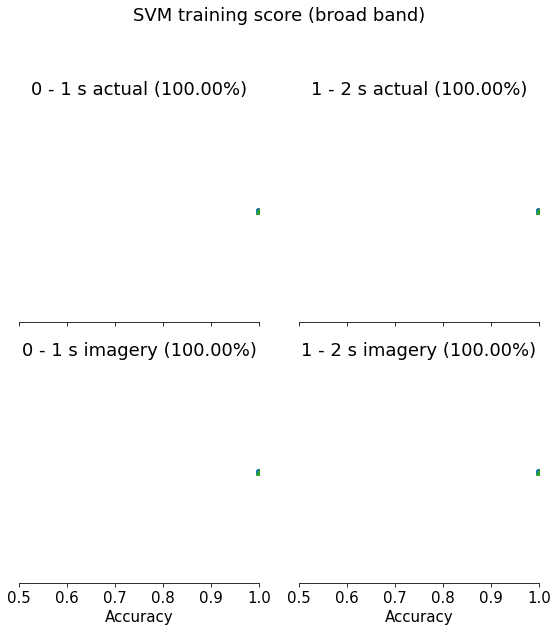

In [ ]:
#@title
#@markdown Run to plot out these accuracy scores.
condi_name = ['actual', 'imagery']
time_name = ['0-2s']

f, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize = (9,9))
    
for itime in range(2):
  for icondi in range(2):
    ax=axes[icondi, itime] 
    #plt.subplots_adjust(hspace=0.05, wspace=0.1)
    
    ax.boxplot(train_acc[itime, :, icondi], vert=False, widths=.7, showmeans=True)
    ax.scatter(train_acc[itime, :, icondi], np.ones(7))
    ax.set(
      yticks=[],
      title=f"{itime} - {itime + 1} s {condi_name[icondi]} ({train_acc[itime, :, icondi].mean():.2%})"
    )

    if icondi == 1:
      ax.set(xlabel="Accuracy")
    ax.spines["left"].set_visible(False)
    plt.xlim(0.5, 1)

plt.tight_layout()
title = "SVM training score (%s)" % band_name
plt.suptitle(title, x=0.5, y=1.1)
plt.show()

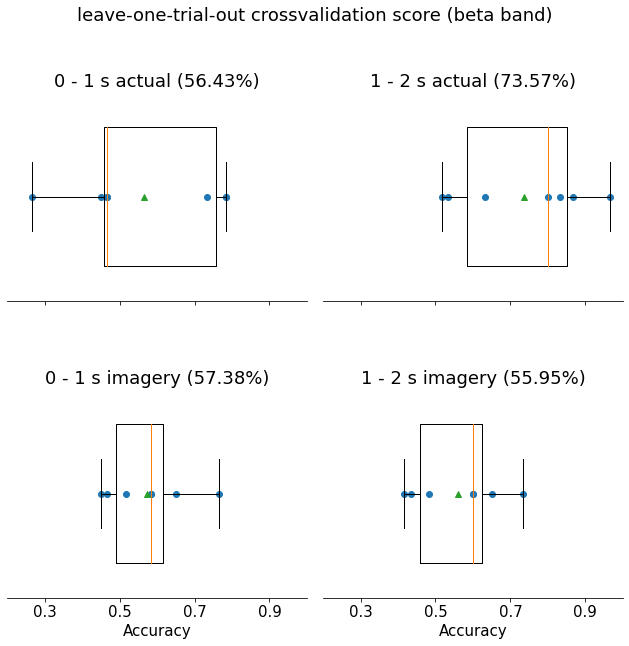

In [10]:
#@title
#@markdown Run to plot out these accuracy scores.
condi_name = ['actual', 'imagery']
time_name = ['0-2s']

f, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize = (9,9))
    
for itime in range(2):
  for icondi in range(2):
    ax=axes[icondi, itime] 
    #plt.subplots_adjust(hspace=0.05, wspace=0.1)
    
    ax.boxplot(acc[itime, :, icondi], vert=False, widths=.4, showmeans=True)
    ax.scatter(acc[itime, :, icondi], np.ones(7))
    ax.set(
      yticks=[],
      xticks=[0.3, 0.5, 0.7, 0.9],
      ylim=(0.7, 1.5)
    )

    ax.set_title(f"{itime} - {itime + 1} s {condi_name[icondi]} ({acc[itime, :, icondi].mean():.2%})",y=0.75)

    if icondi == 1:
      ax.set(xlabel="Accuracy")
    ax.spines["left"].set_visible(False)
    plt.xlim(0.2, 1)

plt.tight_layout()
title = "leave-one-trial-out crossvalidation score (%s)" % band_name
plt.suptitle(title, x=0.5, y=1.0)
plt.show()

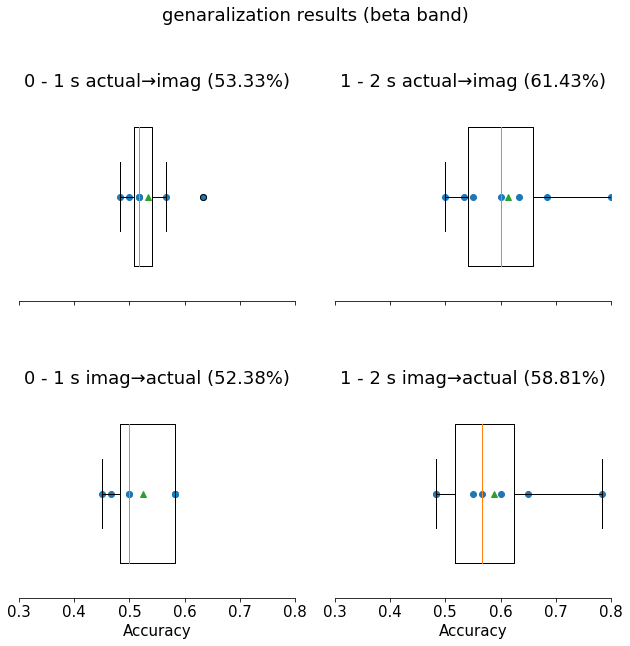

In [11]:
#@title
#@markdown Run to plot out these accuracy scores.
condi_name = ['actual→imag', 'imag→actual']
time_name = ['0-2s']

f, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize = (9,9))
    
for itime in range(2):
  for icondi in range(2):
    ax=axes[icondi, itime] 
    #plt.subplots_adjust(hspace=0.05, wspace=0.1)
    
    ax.boxplot(gen_acc[itime, :, icondi], vert=False, widths=.4, showmeans=True)
    ax.scatter(gen_acc[itime, :, icondi], np.ones(7))
    ax.set(
      yticks=[],
      ylim=(0.7, 1.5)
    )

    ax.set_title(f"{itime} - {itime + 1} s {condi_name[icondi]} ({gen_acc[itime, :, icondi].mean():.2%})",y=0.75)

    if icondi == 1:
      ax.set(xlabel="Accuracy")
    ax.spines["left"].set_visible(False)
    plt.xlim(0.3, 0.8)

plt.tight_layout()
title = "genaralization results (%s)" % band_name
plt.suptitle(title, x=0.5, y=1.0)
plt.show()